In [13]:
import timm
import numpy as np
import pandas as pd
import time
import torch
from tqdm.notebook import tqdm 

import torch.utils.benchmark as benchmark
from torch.utils.data import Dataset, DataLoader

In [2]:
WARM_UP = 10
BATCH_SIZE = 4
NUM_TEST = 100

In [3]:
!nvidia-smi

Sat Jul  3 10:59:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 455.45.01    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  RTX A6000           On   | 00000000:09:00.0 Off |                  Off |
| 30%   49C    P0    82W / 250W |     41MiB / 48682MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
df_models = pd.read_csv("results-imagenet-real.csv")
# use models with img size 224
modellist = df_models[df_models["img_size"]==224]["model"]
df_models.head()

,model,top1,top1_err,top5,top5_err,param_count,img_size,cropt_pct,interpolation,top1_diff,top5_diff,rank_diff
0,tf_efficientnet_l2_ns,90.563,9.437,98.779,1.221,480.31,800,0.960,bicubic,2.211,0.129,0
1,tf_efficientnet_l2_ns_475,90.537,9.463,98.710,1.290,480.31,475,0.936,bicubic,2.303,0.164,0
2,cait_m48_448,90.196,9.804,98.484,1.516,356.46,448,1.000,bicubic,3.712,0.730,3
3,vit_large_patch16_384,90.196,9.804,98.661,1.339,304.72,384,1.000,bicubic,3.116,0.361,0
4,tf_efficientnet_b7_ns,90.100,9.900,98.614,1.386,66.35,600,0.949,bicubic,3.260,0.520,0


In [5]:
class RandomDataset(Dataset):
    def __init__(self,  length):
        self.len = length
        self.data = torch.randn( 3, 224, 224,length)

    def __getitem__(self, index):
        return self.data[:,:,:,index]

    def __len__(self):
        return self.len

rand_loader = DataLoader(dataset=RandomDataset(BATCH_SIZE*(WARM_UP + NUM_TEST)),
                         batch_size=BATCH_SIZE, shuffle=False,num_workers=8)

In [30]:
# https://github.com/ryujaehun/pytorch-gpu-benchmark/blob/master/benchmark_models.py
def inference(modelname, benchmark, half=False):
    with torch.no_grad():
        model = timm.create_model(modelname,)
        model=model.to('cuda')
        model.eval()
        precision = "float"
        durations = []
        print(f'Benchmarking Inference {modelname} ')
        for step,img in enumerate(rand_loader):
            img=getattr(img,precision)()
            torch.cuda.synchronize()
            start = time.time()
            model(img.to('cuda'))
            torch.cuda.synchronize()
            end = time.time()
            if step >= WARM_UP:
                durations.append((end - start)*1000)
        print(f'{modelname} model average inference time : {sum(durations)/len(durations)}ms')
        
        if half:
            durations_half = []
            print(f'Benchmarking Inference half precision type {modelname} ')
            model.half()
            precision = "half"
            for step,img in enumerate(rand_loader):
                img=getattr(img,precision)()
                torch.cuda.synchronize()
                start = time.time()
                model(img.to('cuda'))
                torch.cuda.synchronize()
                end = time.time()
                if step >= WARM_UP:
                    durations_half.append((end - start)*1000)
            print(f'{modelname} half model average inference time : {sum(durations_half)/len(durations_half)}ms')
            
        if half:
            benchmark[modelname] = {"fp32": np.mean(durations), "fp16": np.mean(durations_half), "top1": df_models[df_models["model"]==modelname]["top1"]}
        else:
            benchmark[modelname] = {"fp32": np.mean(durations), "top1": float(df_models[df_models["model"]==modelname]["top1"])}
    return benchmark

In [34]:
benchmark = {}

# inference float precision
for i,modelname in tqdm(enumerate((modellist))):
    try:
        benchmark = inference(modelname, benchmark)
    except:
        print("pass {}".format(modelname))
benchmark

Benchmarking Inference swin_large_patch4_window7_224 
swin_large_patch4_window7_224 model average inference time : 19.50279474258423ms
Benchmarking Inference vit_large_patch16_224 
vit_large_patch16_224 model average inference time : 24.370009899139404ms
Benchmarking Inference swin_base_patch4_window7_224 
swin_base_patch4_window7_224 model average inference time : 15.764214992523193ms
Benchmarking Inference ig_resnext101_32x48d 
ig_resnext101_32x48d model average inference time : 360.5432891845703ms
Benchmarking Inference ig_resnext101_32x32d 
ig_resnext101_32x32d model average inference time : 241.9998860359192ms
Benchmarking Inference resmlp_big_24_224_in22ft1k 
resmlp_big_24_224_in22ft1k model average inference time : 36.22174024581909ms
Benchmarking Inference vit_base_patch16_224 
vit_base_patch16_224 model average inference time : 8.107953071594238ms
Benchmarking Inference ig_resnext101_32x16d 
ig_resnext101_32x16d model average inference time : 119.11271810531616ms
Benchmarking 

Benchmarking Inference gluon_seresnext101_32x4d 
gluon_seresnext101_32x4d model average inference time : 58.40898513793945ms
Benchmarking Inference resnet50d 
resnet50d model average inference time : 13.604111671447754ms
Benchmarking Inference gluon_seresnext101_64x4d 
gluon_seresnext101_64x4d model average inference time : 80.38221836090088ms
Benchmarking Inference vit_base_patch32_224 
vit_base_patch32_224 model average inference time : 6.309616565704346ms
Benchmarking Inference gluon_resnet152_v1d 
gluon_resnet152_v1d model average inference time : 36.075589656829834ms
Benchmarking Inference seresnet50 
seresnet50 model average inference time : 19.72234010696411ms
Benchmarking Inference repvgg_b2g4 
repvgg_b2g4 model average inference time : 23.099920749664307ms
Benchmarking Inference gluon_resnet101_v1d 
gluon_resnet101_v1d model average inference time : 24.865880012512207ms
Benchmarking Inference resnet50 
resnet50 model average inference time : 13.070471286773682ms
Benchmarking I

selecsls60b model average inference time : 15.792901515960693ms
Benchmarking Inference hrnet_w32 
hrnet_w32 model average inference time : 77.26882696151733ms
Benchmarking Inference tf_efficientnetv2_b0 
tf_efficientnetv2_b0 model average inference time : 17.512075901031494ms
Benchmarking Inference regnetx_040 
regnetx_040 model average inference time : 24.476487636566162ms
Benchmarking Inference efficientnet_es 
efficientnet_es model average inference time : 9.59014892578125ms
Benchmarking Inference hrnet_w30 
hrnet_w30 model average inference time : 77.46355295181274ms
Benchmarking Inference tf_mixnet_l 
tf_mixnet_l model average inference time : 24.727728366851807ms
Benchmarking Inference wide_resnet101_2 
wide_resnet101_2 model average inference time : 31.62684440612793ms
Benchmarking Inference dla60x 
dla60x model average inference time : 25.395286083221436ms
Benchmarking Inference legacy_seresnet101 
legacy_seresnet101 model average inference time : 37.76135444641113ms
Benchmarki

tf_mixnet_s model average inference time : 20.533647537231445ms
Benchmarking Inference repvgg_b0 
repvgg_b0 model average inference time : 14.523680210113525ms
Benchmarking Inference deit_tiny_distilled_patch16_224 
deit_tiny_distilled_patch16_224 model average inference time : 6.505832672119141ms
Benchmarking Inference mixer_b16_224 
mixer_b16_224 model average inference time : 6.005053520202637ms
Benchmarking Inference pit_ti_distilled_224 
pit_ti_distilled_224 model average inference time : 11.327447891235352ms
Benchmarking Inference hrnet_w18_small_v2 
hrnet_w18_small_v2 model average inference time : 39.86715793609619ms
Benchmarking Inference tf_efficientnet_lite0 
tf_efficientnet_lite0 model average inference time : 8.792951107025146ms
Benchmarking Inference resnet26 
resnet26 model average inference time : 7.5565314292907715ms
Benchmarking Inference tf_mobilenetv3_large_100 
tf_mobilenetv3_large_100 model average inference time : 11.876115798950195ms
Benchmarking Inference tv_de

{'swin_large_patch4_window7_224': {'fp32': 19.50279474258423, 'top1': 89.796},
 'vit_large_patch16_224': {'fp32': 24.370009899139404, 'top1': 89.314},
 'swin_base_patch4_window7_224': {'fp32': 15.764214992523193, 'top1': 89.145},
 'ig_resnext101_32x48d': {'fp32': 360.5432891845703, 'top1': 89.12},
 'ig_resnext101_32x32d': {'fp32': 241.9998860359192, 'top1': 89.111},
 'resmlp_big_24_224_in22ft1k': {'fp32': 36.22174024581909,
  'top1': 89.01100000000001},
 'vit_base_patch16_224': {'fp32': 8.107953071594238, 'top1': 88.866},
 'ig_resnext101_32x16d': {'fp32': 119.11271810531616, 'top1': 88.834},
 'swsl_resnext101_32x8d': {'fp32': 63.61705303192139, 'top1': 88.77},
 'vit_base_patch16_224_miil': {'fp32': 7.891795635223389,
  'top1': 88.73700000000001},
 'pit_b_distilled_224': {'fp32': 23.16471815109253, 'top1': 88.676},
 'cait_s24_224': {'fp32': 17.449767589569092, 'top1': 88.447},
 'resmlp_big_24_distilled_224': {'fp32': 36.24388933181763, 'top1': 88.443},
 'vit_large_r50_s32_224': {'fp32':

In [35]:
df_results = pd.DataFrame(benchmark).T
df_results

,fp32,top1
swin_large_patch4_window7_224,19.502795,89.796
vit_large_patch16_224,24.370010,89.314
swin_base_patch4_window7_224,15.764215,89.145
ig_resnext101_32x48d,360.543289,89.120
ig_resnext101_32x32d,241.999886,89.111
...,...,...
tf_mobilenetv3_small_100,10.368042,74.717
dla46x_c,18.569305,73.647
tf_mobilenetv3_small_075,10.742824,72.812
dla46_c,11.950483,72.601


In [37]:
df_results.to_csv("results_fp32_224.csv")

## plot

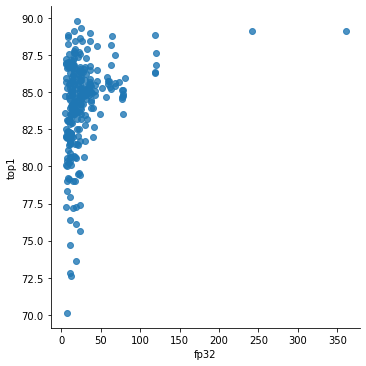

In [40]:
import seaborn as sns
sns.lmplot(y='top1', x='fp32',  
           data=df_results, logx=True,
           fit_reg=False, scatter_kws={'alpha':0.8})